In [ ]:
# Import Modules
import numpy as np
from astropy import units as u
from astropy import constants as const

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from ReadFile import Read
from CenterOfMass2 import CenterOfMass

# Critical density of the universe in 1e10 M_Sun and kpc
pcrit = 1.277e-8 

# Plan for Research Project:

# Part 1: Find the halo denisty profile of the merger remnant.
Note: Using snap 801 for MW and M31

Steps:
1) Extract halo information of MW and M31 and add them together
2) Sum mass enclosed in each shell
3) Divide mass by spherical volume of the shell
4) Store the density value in an array
5) Plot that density as a function of radius of the shell

In [2]:
def find_nearest(array, value):
    ''' 
    Find the nearest value in an array to an input value (from stack overflow)
    Inputs:
        array: array
            Array of values
        value: float
            Float to match nearest value in  array with
    Outputs:
        array[idx]: float
            Element in array closest to input value
    '''
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [3]:
# Get file info
filename = "Merger_801.txt"
Remnant_t, Remnant_p, Remnant_d = Read(filename)

In [4]:
# get COM of remnant
Remnant = CenterOfMass(filename, 1)

# Error tolerance
delta = 0.01
# Decrease volume factor
voldec = 2.0

# This is the center of mass of the remnant
Remnant_COMp = Remnant.COM_P(delta, voldec)

In [5]:
def Integrator(rmax, dr):
    '''
    Make spheres and sum masses inside
    Inputs:
        rmax: float
            Maximum radius to be considered in kpc
        dr: float
            Added radius for each shell
    Outputs:        radii: numpy array
            Radius of sphere
        masses: numpy array
            Total mass in each sphere
    '''
    # Determine particle distance from COM
    xnew = abs(Remnant_COMp[0].value - Remnant_d['x'])
    ynew = abs(Remnant_COMp[1].value - Remnant_d['y'])
    znew = abs(Remnant_COMp[2].value - Remnant_d['z'])

    # Find magnitude of particle distance
    rnew = np.sqrt(xnew**2 + ynew**2 + znew**2)
    
    # Initial radius
    r0 = 0.1

    # Initialize radius and mass array
    radii = np.arange(r0, rmax, dr)
    masses = np.zeros(len(radii))

    for radius_index in range(len(radii)):
        # Create index where particles are within sphere
        index = np.where(rnew < radii[radius_index])

        # Take masses of the particles in sphere
        masses[radius_index] = np.sum(Remnant_d['m'][index])
        '''
        # Fix if nan is returned
        if masses[radius_index] == 'nan':
            masses[radius_index] == 0
        '''
    return radii, masses

In [6]:
def density(rmax, dr):
    ''' 
    Convert mass values into spherical density values 
    Inputs:
        rmax: float
            Maximum radius to be considered
        dr: float
            Radius step size
    Outputs:
        radii: numpy array
            Array of radii
        densities: numpy array
            Array of densities at radius values
    '''
    # Integrate masses with respect to radius
    radii, masses = Integrator(rmax, dr)

    # Convert radii to sphere volume
    sphere_vol = (4/3) * np.pi * radii**3

    # Convert masses and volumes to densities
    densities = (masses)/sphere_vol

    return radii, densities

In [7]:
# Changed .001 to .1 to save time 
Halo_density = density(280, .1)

In [8]:
# Define 200 times the critical density
rho200 = 200*pcrit
# Find closest density in halo array to 200rhocrit
rho200_index = find_nearest(Halo_density[1], rho200)
# Find index of corresponding array
R200_index = np.where(rho200_index == Halo_density[1])
# Find R200 radius value
R200 = Halo_density[0][R200_index]
print(R200) # R200


[278.7]


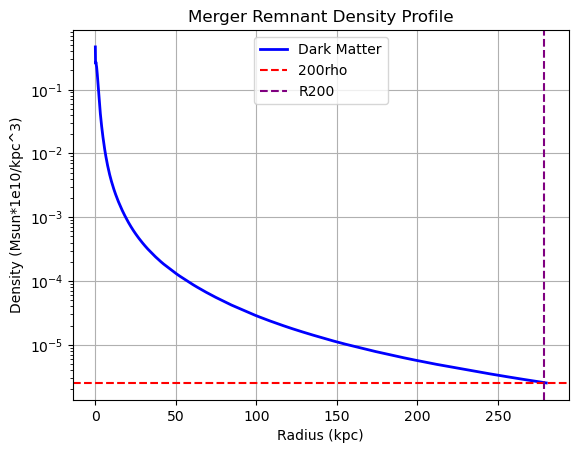

In [9]:
# Initialize Plots
fig, ax = plt.subplots()
# Plotting particle masses at given radius
ax.plot(Halo_density[0], Halo_density[1], 'b', linewidth = 2, label = 'Dark Matter')

# 200rhocrit line
ax.axhline(y=200*pcrit, color='r', linestyle='--', label='200rho')
# R200 line
ax.axvline(x=R200, color='purple', linestyle='--', label='R200')

# Formatting
ax.set_yscale('log')
ax.grid()
ax.set(title='Merger Remnant Density Profile', xlabel='Radius (kpc)', ylabel='Density (Msun*1e10/kpc^3)')
ax.legend(loc='best')